In [1]:
import geopandas as gpd
import shapely
import contextily as cx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from functools import partial

In [2]:
gdf = gpd.read_file("data/gr400_vallee_jordanne.shp")

In [5]:
# Cut linestrings at max lenght
max_length = int(gdf.length.sum()/500)
gs = shapely.segmentize(gdf["geometry"], max_segment_length=max_length)
gdf = gdf.set_geometry(gs, crs=gdf.crs)

In [6]:
# Cut linestrings into segments
segments = []
for index, row in gdf.iterrows():
    coords = list(row["geometry"].coords)
    for first_point, second_point in zip(coords[:-1], coords[1:]):
        segments.append(shapely.geometry.LineString((first_point, second_point)))
gs = gpd.GeoSeries(segments)
gdf_tmp = gpd.GeoDataFrame(geometry=gs)
gdf = gdf_tmp.set_crs(gdf.crs)

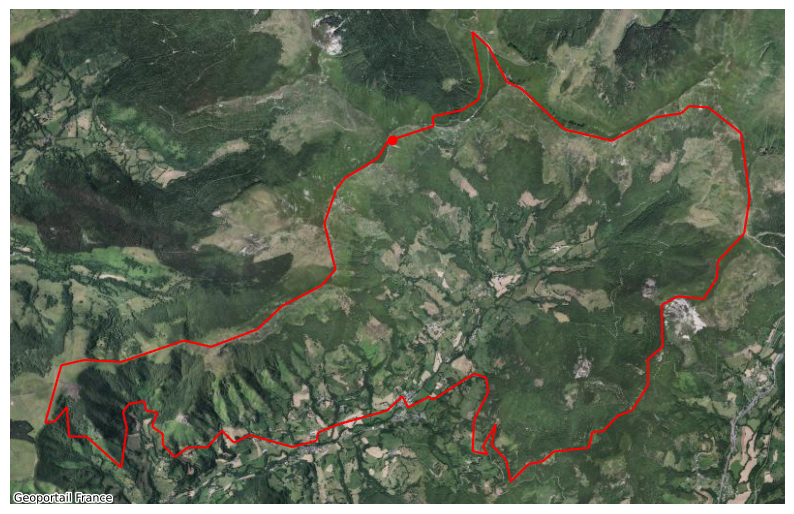

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_axis_off()

gdf.plot(alpha=0, ax=ax)
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.GeoportailFrance.Orthoimagery_Orthophotos2020)
scat = ax.scatter(x=gdf.loc[0, "geometry"].coords[1][0], y=gdf.loc[0, "geometry"].coords[1][1], color="r")

def update(frame, gdf, ax):
    gdf.loc[[frame]].plot(edgecolor="r", ax=ax)
    scat.set_offsets(gdf.loc[frame, "geometry"].coords[1])
    return (scat,)

ani = animation.FuncAnimation(fig=fig, func=partial(update, gdf=gdf, ax=ax), frames=gdf.index, interval=20)
HTML(ani.to_html5_video())
# ani.save(filename="output/gpx_film.mp4", writer="ffmpeg")